In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:45739 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.46 GB


In [18]:
import numpy as np
import dask.bag as db
import yt
from yt.utilities.lib.pixelization_routines import pixelize_cartesian

ds = yt.load("sedov_piernik.h5")

z = 0.0

data = []
for grid in ds.index.grids:
    data.append(
        {
            "data": grid["density"].d,
            "LE": grid.LeftEdge.d,
            "RE": grid.RightEdge.d,
            "dds": grid.dds.d,
        }
    )


def intersects(chunk):
    return chunk["LE"][2] <= z and z < chunk["RE"][2]


def compute(chunk):
    dds = chunk["dds"]
    LE = chunk["LE"] + dds * 0.5
    RE = chunk["RE"] - dds * 0.5
    nslice = int((z - LE[2]) * dds[2])

    data = chunk["data"][..., nslice]
    N = data.shape
    px, py = np.mgrid[LE[0] : RE[0] : N[0] * 1j, LE[1] : RE[1] : N[1] * 1j]

    return {
        "data": data.ravel().astype(np.float64),
        "px": px.ravel(),
        "py": py.ravel(),
        "pdx": (np.ones(N) * dds[0]).ravel(),
        "pdy": (np.ones(N) * dds[1]).ravel(),
    }


def combine_chunks(acc, chunk):
    for key in ("data", "px", "py", "pdx", "pdy"):
        acc[key] = np.concatenate((acc[key], chunk[key]))
    return acc

b = db.from_sequence(data)
data_source = b.filter(intersects).map(compute).fold(combine_chunks).compute()

buff = np.zeros((512, 512), dtype="f8")
period = ds.domain_width.d
antialias = True
periodic = False
bounds = [
    ds.domain_left_edge[0].d,
    ds.domain_right_edge[0].d,
    ds.domain_left_edge[1].d,
    ds.domain_right_edge[1].d,
]
pixelize_cartesian(
    buff,
    data_source["px"],
    data_source["py"],
    data_source["pdx"],
    data_source["pdy"],
    data_source["data"],
    bounds,
    int(antialias),
    period,
    int(periodic),
)

yt : [WARNING  ] 2020-02-27 15:13:56,982 'field_units' was overridden by 'dataset_units/density'
yt : [WARNING  ] 2020-02-27 15:13:56,985 'field_units' was overridden by 'dataset_units/energy_density'
yt : [WARNING  ] 2020-02-27 15:13:56,990 'field_units' was overridden by 'dataset_units/level'
yt : [WARNING  ] 2020-02-27 15:13:57,006 'field_units' was overridden by 'dataset_units/velocity_x'
yt : [WARNING  ] 2020-02-27 15:13:57,011 'field_units' was overridden by 'dataset_units/velocity_y'
yt : [WARNING  ] 2020-02-27 15:13:57,019 'field_units' was overridden by 'dataset_units/velocity_z'
yt : [INFO     ] 2020-02-27 15:13:57,043 Parameters: current_time              = [5.07311964e-05]
yt : [INFO     ] 2020-02-27 15:13:57,045 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2020-02-27 15:13:57,045 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2020-02-27 15:13:57,046 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-02-27

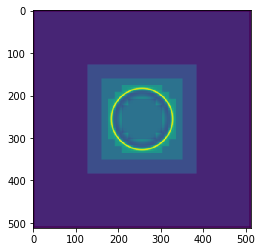

In [19]:
%matplotlib inline
from matplotlib.pyplot import imshow
imshow(buff)